In [145]:
import sqlite3
from pandas.api.types import is_string_dtype, is_numeric_dtype
import re
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from time import time
from sklearn.decomposition import PCA, FastICA
from sklearn.pipeline import Pipeline
import warnings

warnings.simplefilter("ignore")

In [28]:
! ls ../

data   kaggle


In [29]:
path = "../data/"  #Insert path here
database = path + 'database.sqlite'
conn = sqlite3.connect(database)

In [39]:
%%time
player_data = pd.read_sql("SELECT * FROM Player;", conn)
player_stats_data = pd.read_sql("SELECT * FROM Player_Attributes;", conn)
team_data = pd.read_sql("SELECT * FROM Team;", conn)
match_data = pd.read_sql("SELECT * FROM Match;", conn)
country_data = pd.read_sql("SELECT * FROM Country;", conn)

CPU times: user 5.71 s, sys: 2.15 s, total: 7.87 s
Wall time: 30.9 s


In [41]:
league_data = pd.read_sql("SELECT * FROM League;", conn)

In [127]:
team_stats_data = pd.read_sql("SELECT * FROM Team_Attributes;", conn)

In [31]:
player_data[:2]

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146


In [47]:
player_stats_data.shape

(183978, 42)

In [32]:
player_stats_data[:2]

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0


In [33]:
#  unique teams

len(team_data.team_long_name.unique())

296

In [34]:
team_data[:2]

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC


In [46]:
match_data[:4]

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.0,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.8,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.5,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.5,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50


In [40]:
country_data[:2]

,id,name
0,1,Belgium
1,1729,England


In [43]:
league_data[:4]

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga


In [36]:
# shape of data

print('player_data : ', player_data.shape)
print('player_stats_data : ', player_stats_data.shape)
print('team_data : ', team_data.shape)
print('match_data : ', match_data.shape)

player_data :  (11060, 7)
player_stats_data :  (183978, 42)
team_data :  (299, 5)
match_data :  (25979, 115)


In [48]:
rows = ["country_id", "league_id", "season", "stage", "date", "match_api_id", "home_team_api_id", 
        "away_team_api_id", "home_team_goal", "away_team_goal", "home_player_1", "home_player_2",
        "home_player_3", "home_player_4", "home_player_5", "home_player_6", "home_player_7", 
        "home_player_8", "home_player_9", "home_player_10", "home_player_11", "away_player_1",
        "away_player_2", "away_player_3", "away_player_4", "away_player_5", "away_player_6",
        "away_player_7", "away_player_8", "away_player_9", "away_player_10", "away_player_11"]
match_data_nona = match_data.dropna(subset = rows, inplace = False)
#match_data_nona = match_data.tail(1500)

In [49]:
# after removing nas

print('match_data : ', match_data_nona.shape)

match_data :  (21374, 115)


In [59]:
league_data

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


In [60]:
match_data_epl = match_data_nona[match_data_nona.league_id == 1729]

In [61]:
match_data_epl.shape

(2962, 115)

In [64]:
print(match_data_epl.date.min())
print(match_data_epl.date.max())

2008-08-16 00:00:00
2016-05-17 00:00:00


In [65]:
players = ['home_player_1', 'home_player_2', 'home_player_3', "home_player_4", "home_player_5",
           "home_player_6", "home_player_7", "home_player_8", "home_player_9", "home_player_10",
           "home_player_11", "away_player_1", "away_player_2", "away_player_3", "away_player_4",
           "away_player_5", "away_player_6", "away_player_7", "away_player_8", "away_player_9",
           "away_player_10", "away_player_11"] # columns of interest for fengineering
columns = players + ['date', 'match_api_id']
player_stats_data = player_stats_data.sort_values('date', ascending=False)
fifa_stats = pd.DataFrame() # create empty fifa stats
feature = 'overall_rating'
for _, match in match_data_epl.iterrows():
    first_match = match[columns]
    player_idxs = first_match[players].values
    date = first_match.date
    match_id = first_match.match_api_id
    sub_data = player_stats_data[player_stats_data.date < date]
    player_stats = sub_data[sub_data['player_api_id'].isin(player_idxs)].\
        groupby('player_api_id').first()[feature][player_idxs]
    player_stats.index = players
    match_stats_df = pd.DataFrame(player_stats).T
    match_stats_df['match_api_id'] = match_id
    fifa_stats = pd.concat([fifa_stats, match_stats_df])

In [69]:
fifa_stats.shape

(2962, 23)

### Outcome column 

* Just adding columns showing whether home team won/lost or match was draw

In [95]:
match_data_epl.reset_index(inplace=True)

In [100]:
def home_outcome_func(x):
    if x.home_team_goal > x.away_team_goal:
        return 'win'
    elif x.home_team_goal == x.away_team_goal:
        return 'draw'
    else: return 'lost'

match_data_epl['outcome_home'] = match_data_epl.apply(home_outcome_func, axis=1)   

In [107]:
match_data_epl.loc[:2, ['home_team_goal', 'away_team_goal', 'outcome_home']]

,home_team_goal,away_team_goal,outcome_home
0,1.0,1.0,draw
1,1.0,0.0,win
2,0.0,1.0,lost


### Filter only relavant matches (without NAs)

In [182]:
fifa_match_ids = list(fifa_stats.match_api_id)

In [183]:
len(fifa_match_ids)

2962

In [184]:
fifa_match_ids[:1]

[489042]

In [189]:
match_filter = match_data_epl[match_data_epl.match_api_id.isin(fifa_match_ids)]

In [190]:
match_filter.shape

(2962, 117)

### Team attribtutes

#### For both home and away team, add team class attributes (bins) from `Team Attributes` table

In [212]:
team_stats_data.shape

(1458, 25)

In [215]:
team_stats_data.sort_values(by=['team_api_id', 'date'])[:8]

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
1112,1113,874,1601,2010-02-22 00:00:00,30,Slow,NaN,Little,40,Mixed,...,70,Lots,Organised,65,Medium,60,Press,50,Normal,Cover
1113,1114,874,1601,2011-02-22 00:00:00,48,Balanced,NaN,Little,51,Mixed,...,51,Normal,Organised,46,Medium,48,Press,50,Normal,Cover
1114,1115,874,1601,2012-02-22 00:00:00,53,Balanced,NaN,Little,55,Mixed,...,50,Normal,Organised,43,Medium,44,Press,49,Normal,Cover
1115,1116,874,1601,2013-09-20 00:00:00,53,Balanced,NaN,Little,55,Mixed,...,50,Normal,Organised,43,Medium,44,Press,49,Normal,Cover
1116,1117,874,1601,2014-09-19 00:00:00,53,Balanced,48.0,Normal,38,Mixed,...,50,Normal,Organised,43,Medium,44,Press,49,Normal,Cover
1117,1118,874,1601,2015-09-10 00:00:00,47,Balanced,48.0,Normal,38,Mixed,...,50,Normal,Organised,43,Medium,44,Press,49,Normal,Cover
940,941,100087,1773,2012-02-22 00:00:00,52,Balanced,NaN,Little,50,Mixed,...,54,Normal,Organised,43,Medium,44,Press,50,Normal,Cover
941,942,100087,1773,2013-09-20 00:00:00,52,Balanced,NaN,Little,50,Mixed,...,54,Normal,Organised,43,Medium,44,Press,50,Normal,Cover


In [133]:
team_stats_data.buildUpPlaySpeedClass.unique()

array(['Balanced', 'Fast', 'Slow'], dtype=object)

In [137]:
class_columns = [col for col in team_stats_data.columns if 'Class' in col]
class_columns

['buildUpPlaySpeedClass',
 'buildUpPlayDribblingClass',
 'buildUpPlayPassingClass',
 'buildUpPlayPositioningClass',
 'chanceCreationPassingClass',
 'chanceCreationCrossingClass',
 'chanceCreationShootingClass',
 'chanceCreationPositioningClass',
 'defencePressureClass',
 'defenceAggressionClass',
 'defenceTeamWidthClass',
 'defenceDefenderLineClass']

In [152]:
cols_keep = class_columns+ ['team_api_id']

In [153]:
team_class_stats = team_stats_data.loc[:,cols_keep]

In [154]:
team_class_stats[:2]

,buildUpPlaySpeedClass,buildUpPlayDribblingClass,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassingClass,chanceCreationCrossingClass,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressureClass,defenceAggressionClass,defenceTeamWidthClass,defenceDefenderLineClass,team_api_id
0,Balanced,Little,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover,9930
1,Balanced,Normal,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover,9930


In [146]:
def convert_cats(train, col_not_convert = [], test = None):
    """
    Convert columns in a training and test dataframe
    into category codes 
    
    train: Training dataframe
    col_not_convert: list of columns which are string type and which you don't want to convert
    test: Test/ Validation set (Mapping from category codes from training)
    """
    
    for n,c in train.items():
        if is_string_dtype(c) and n not in col_not_convert : train[n] = c.astype('category').cat.as_ordered()
    
    if test is not None:
        for n,c in test.items():
            if (n in train.columns) and (train[n].dtype.name=='category'):
                test[n] = pd.Categorical(c, categories=train[n].cat.categories, ordered=True)
            
    cols = list(train.columns[train.dtypes == 'category'])
    for c in cols:
        train[c] = train[c].astype('category').cat.codes
        if test is not None: test[c] = test[c].astype('category').cat.codes


In [155]:
convert_cats(team_class_stats, col_not_convert=['team_api_id'])

In [156]:
team_class_stats[:2]

,buildUpPlaySpeedClass,buildUpPlayDribblingClass,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassingClass,chanceCreationCrossingClass,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressureClass,defenceAggressionClass,defenceTeamWidthClass,defenceDefenderLineClass,team_api_id
0,0,0,1,1,0,2,2,1,2,2,1,0,9930
1,0,2,1,1,0,2,2,1,2,2,1,0,9930


In [191]:
match_data_apis = match_filter.loc[:,['match_api_id', 'away_team_api_id', 'home_team_api_id']]

In [192]:
match_data_apis = match_data_apis.astype(int)

In [193]:
match_data_apis[:2]

,match_api_id,away_team_api_id,home_team_api_id
0,489042,10261,10260
1,489043,8659,9825


In [202]:
match_data_apis.merge(team_class_stats,
                      how='left',
                      left_on='away_team_api_id',
                      right_on='team_api_id').shape

(17772, 16)

In [ ]:
merge(team_class_stats,
                                                    how = 'left', 
                                                    left_on = 'home_team_api_id',
                                                    suffixes=('_away', '_home'),
                                                    right_on = 'team_api_id')

### TO DO??

In [382]:
# def get_match_label(match):
#     ''' Derives a label for a given match. '''
    
#     #Define variables
#     home_goals = match['home_team_goal']
#     away_goals = match['away_team_goal']
     
#     label = pd.DataFrame()
#     label.loc[0,'match_api_id'] = match['match_api_id'] 

#     #Identify match label  
#     if home_goals > away_goals:
#         label.loc[0,'label'] = "Win"
#     if home_goals == away_goals:
#         label.loc[0,'label'] = "Draw"
#     if home_goals < away_goals:
#         label.loc[0,'label'] = "Defeat"

#     #Return label        
#     return label.loc[0]
    


# def get_overall_fifa_rankings(fifa, get_overall = False):
#     ''' Get overall fifa rankings from fifa data. '''
      
#     temp_data = fifa
    
#     #Check if only overall player stats are desired
#     if get_overall == True:
        
#         #Get overall stats
#         data = temp_data.loc[:,(fifa.columns.str.contains('overall_rating'))]
#         data.loc[:,'match_api_id'] = temp_data.loc[:,'match_api_id']
#     else:
        
#         #Get all stats except for stat date
#         cols = fifa.loc[:,(fifa.columns.str.contains('date_stat'))]
#         temp_data = fifa.drop(cols.columns, axis = 1)        
#         data = temp_data
    
#     #Return data
#     return data

# def get_last_matches(matches, date, team, x = 10):
#     ''' Get the last x matches of a given team. '''
    
#     #Filter team matches from matches
#     team_matches = matches[(matches['home_team_api_id'] == team) | (matches['away_team_api_id'] == team)]
                           
#     #Filter x last matches from team matches
#     last_matches = team_matches[team_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:x,:]
    
#     #Return last matches
#     return last_matches
    
# def get_last_matches_against_eachother(matches, date, home_team, away_team, x = 10):
#     ''' Get the last x matches of two given teams. '''
    
#     #Find matches of both teams
#     home_matches = matches[(matches['home_team_api_id'] == home_team) & (matches['away_team_api_id'] == away_team)]    
#     away_matches = matches[(matches['home_team_api_id'] == away_team) & (matches['away_team_api_id'] == home_team)]  
#     total_matches = pd.concat([home_matches, away_matches])
    
#     #Get last x matches
#     try:    
#         last_matches = total_matches[total_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:x,:]
#     except:
#         last_matches = total_matches[total_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:total_matches.shape[0],:]
        
#         #Check for error in data
#         if(last_matches.shape[0] > x):
#             print("Error in obtaining matches")
            
#     #Return data
#     return last_matches
    
# def get_goals(matches, team):
#     ''' Get the goals of a specfic team from a set of matches. '''
    
#     #Find home and away goals
#     home_goals = int(matches.home_team_goal[matches.home_team_api_id == team].sum())
#     away_goals = int(matches.away_team_goal[matches.away_team_api_id == team].sum())

#     total_goals = home_goals + away_goals
    
#     #Return total goals
#     return total_goals

# def get_goals_conceided(matches, team):
#     ''' Get the goals conceided of a specfic team from a set of matches. '''

#     #Find home and away goals
#     home_goals = int(matches.home_team_goal[matches.away_team_api_id == team].sum())
#     away_goals = int(matches.away_team_goal[matches.home_team_api_id == team].sum())

#     total_goals = home_goals + away_goals

#     #Return total goals
#     return total_goals

# def get_wins(matches, team):
#     ''' Get the number of wins of a specfic team from a set of matches. '''
    
#     #Find home and away wins
#     home_wins = int(matches.home_team_goal[(matches.home_team_api_id == team) & (matches.home_team_goal > matches.away_team_goal)].count())
#     away_wins = int(matches.away_team_goal[(matches.away_team_api_id == team) & (matches.away_team_goal > matches.home_team_goal)].count())

#     total_wins = home_wins + away_wins

#     #Return total wins
#     return total_wins      
    
# def get_match_features(match, matches, x = 10):
#     ''' Create match specific features for a given match. '''
    
#     #Define variables
#     date = match.date
#     home_team = match.home_team_api_id
#     away_team = match.away_team_api_id
    
#     #Get last x matches of home and away team
#     matches_home_team = get_last_matches(matches, date, home_team, x = 10)
#     matches_away_team = get_last_matches(matches, date, away_team, x = 10)
    
#     #Get last x matches of both teams against each other
#     last_matches_against = get_last_matches_against_eachother(matches, date, home_team, away_team, x = 3)
    
#     #Create goal variables
#     home_goals = get_goals(matches_home_team, home_team)
#     away_goals = get_goals(matches_away_team, away_team)
#     home_goals_conceided = get_goals_conceided(matches_home_team, home_team)
#     away_goals_conceided = get_goals_conceided(matches_away_team, away_team)
    
#     #Define result data frame
#     result = pd.DataFrame()
    
#     #Define ID features
#     result.loc[0, 'match_api_id'] = match.match_api_id
#     result.loc[0, 'league_id'] = match.league_id

#     #Create match features
#     result.loc[0, 'home_team_goals_difference'] = home_goals - home_goals_conceided
#     result.loc[0, 'away_team_goals_difference'] = away_goals - away_goals_conceided
#     result.loc[0, 'games_won_home_team'] = get_wins(matches_home_team, home_team) 
#     result.loc[0, 'games_won_away_team'] = get_wins(matches_away_team, away_team)
#     result.loc[0, 'games_against_won'] = get_wins(last_matches_against, home_team)
#     result.loc[0, 'games_against_lost'] = get_wins(last_matches_against, away_team)
    
#     #Return match features
#     return result.loc[0]
    
# def create_feables(matches, fifa, bookkeepers, get_overall = False, horizontal = True, x = 10, verbose = True):
#     ''' Create and aggregate features and labels for all matches. '''

#     #Get fifa stats features
#     fifa_stats = get_overall_fifa_rankings(fifa, get_overall)
    
    
#     if verbose == True:
#         print("Generating match features...")
#     start = time()
    
#     #Get match features for all matches
#     match_stats = matches.apply(lambda x: get_match_features(x, matches, x = 10), axis = 1)
    
#     #Create dummies for league ID feature
#     dummies = pd.get_dummies(match_stats['league_id']).rename(columns = lambda x: 'League_' + str(x))
#     match_stats = pd.concat([match_stats, dummies], axis = 1)
#     match_stats.drop(['league_id'], inplace = True, axis = 1)
    
#     end = time()
#     if verbose == True:
#         print("Match features generated in {:.1f} minutes".format((end - start)/60))
    
#     if verbose == True:    
#         print("Generating match labels...")
#     start = time()
    
#     #Create match labels
#     labels = matches.apply(get_match_label, axis = 1)
#     end = time()
#     if verbose == True:
#         print("Match labels generated in {:.1f} minutes".format((end - start)/60))
    
#     if verbose == True:    
#         print("Generating bookkeeper data...")
#     start = time()
    
#     #Get bookkeeper quotas for all matches
#     bk_data = get_bookkeeper_data(matches, bookkeepers, horizontal = True)
#     bk_data.loc[:,'match_api_id'] = matches.loc[:,'match_api_id']
#     end = time()
#     if verbose == True:
#         print("Bookkeeper data generated in {:.1f} minutes".format((end - start)/60))

#     #Merges features and labels into one frame
#     features = pd.merge(match_stats, fifa_stats, on = 'match_api_id', how = 'left')
#     features = pd.merge(features, bk_data, on = 'match_api_id', how = 'left')
#     feables = pd.merge(features, labels, on = 'match_api_id', how = 'left')
    
#     #Drop NA values
#     feables.dropna(inplace = True)
    
#     #Return preprocessed data
#     return feables
    
# def train_classifier(clf, dm_reduction, X_train, y_train, cv_sets, params, scorer, jobs, use_grid_search = True, 
#                      best_components = None, best_params = None):
#     ''' Fits a classifier to the training data. '''
    
#     #Start the clock, train the classifier, then stop the clock
#     start = time()
    
#     #Check if grid search should be applied
#     if use_grid_search == True: 
        
#         #Define pipeline of dm reduction and classifier
#         estimators = [('dm_reduce', dm_reduction), ('clf', clf)]
#         pipeline = Pipeline(estimators)
        
#         #Grid search over pipeline and return best classifier
#         grid_obj = model_selection.GridSearchCV(pipeline, param_grid = params, scoring = scorer, cv = cv_sets, n_jobs = jobs)
#         grid_obj.fit(X_train, y_train)
#         best_pipe = grid_obj.best_estimator_
#     else:
        
#         #Use best components that are known without grid search        
#         estimators = [('dm_reduce', dm_reduction(n_components = best_components)), ('clf', clf(best_params))]
#         pipeline = Pipeline(estimators)        
#         best_pipe = pipeline.fit(X_train, y_train)
        
#     end = time()
    
#     #Print the results
#     print("Trained {} in {:.1f} minutes".format(clf.__class__.__name__, (end - start)/60))
    
#     #Return best pipe
#     return best_pipe
    
# def predict_labels(clf, best_pipe, features, target):
#     ''' Makes predictions using a fit classifier based on scorer. '''
    
#     #Start the clock, make predictions, then stop the clock
#     start = time()
#     y_pred = clf.predict(best_pipe.named_steps['dm_reduce'].transform(features))
#     end = time()
    
#     #Print and return results
#     print("Made predictions in {:.4f} seconds".format(end - start))
#     return accuracy_score(target.values, y_pred)
    
# def train_calibrate_predict(clf, dm_reduction, X_train, y_train, X_calibrate, y_calibrate, X_test, y_test, cv_sets, params, scorer, jobs, 
#                             use_grid_search = True, **kwargs):
#     ''' Train and predict using a classifer based on scorer. '''
    
#     #Indicate the classifier and the training set size
#     print("Training a {} with {}...".format(clf.__class__.__name__, dm_reduction.__class__.__name__))
    
#     #Train the classifier
#     best_pipe = train_classifier(clf, dm_reduction, X_train, y_train, cv_sets, params, scorer, jobs)
    
#     #Calibrate classifier
#     print("Calibrating probabilities of classifier...")
#     start = time()    
#     clf = CalibratedClassifierCV(best_pipe.named_steps['clf'], cv= 'prefit', method='isotonic')
#     clf.fit(best_pipe.named_steps['dm_reduce'].transform(X_calibrate), y_calibrate)
#     end = time()
#     print("Calibrated {} in {:.1f} minutes".format(clf.__class__.__name__, (end - start)/60))
    
#     # Print the results of prediction for both training and testing
#     print("Score of {} for training set: {:.4f}.".format(clf.__class__.__name__, predict_labels(clf, best_pipe, X_train, y_train)))
#     print("Score of {} for test set: {:.4f}.".format(clf.__class__.__name__, predict_labels(clf, best_pipe, X_test, y_test)))
    
#     #Return classifier, dm reduction, and label predictions for train and test set
#     return clf, best_pipe.named_steps['dm_reduce'], predict_labels(clf, best_pipe, X_train, y_train), predict_labels(clf, best_pipe, X_test, y_test)
        
# def convert_odds_to_prob(match_odds):
#     ''' Converts bookkeeper odds to probabilities. '''
    
#     #Define variables
#     match_id = match_odds.loc[:,'match_api_id']
#     bookkeeper = match_odds.loc[:,'bookkeeper']    
#     win_odd = match_odds.loc[:,'Win']
#     draw_odd = match_odds.loc[:,'Draw']
#     loss_odd = match_odds.loc[:,'Defeat']
    
#     #Converts odds to prob
#     win_prob = 1 / win_odd
#     draw_prob = 1 / draw_odd
#     loss_prob = 1 / loss_odd
    
#     total_prob = win_prob + draw_prob + loss_prob
    
#     probs = pd.DataFrame()
    
#     #Define output format and scale probs by sum over all probs
#     probs.loc[:,'match_api_id'] = match_id
#     probs.loc[:,'bookkeeper'] = bookkeeper
#     probs.loc[:,'Win'] = win_prob / total_prob
#     probs.loc[:,'Draw'] = draw_prob / total_prob
#     probs.loc[:,'Defeat'] = loss_prob / total_prob
    
#     #Return probs and meta data
#     return probs
    
# def get_bookkeeper_data(matches, bookkeepers, horizontal = True):
#     ''' Aggregates bookkeeper data for all matches and bookkeepers. '''
    
#     bk_data = pd.DataFrame()
    
#     #Loop through bookkeepers
#     for bookkeeper in bookkeepers:

#         #Find columns containing data of bookkeeper
#         temp_data = matches.loc[:,(matches.columns.str.contains(bookkeeper))]
#         temp_data.loc[:, 'bookkeeper'] = str(bookkeeper)
#         temp_data.loc[:, 'match_api_id'] = matches.loc[:, 'match_api_id']
        
#         #Rename odds columns and convert to numeric
#         cols = temp_data.columns.values
#         cols[:3] = ['Win','Draw','Defeat']
#         temp_data.columns = cols
#         temp_data.loc[:,'Win'] = pd.to_numeric(temp_data['Win'])
#         temp_data.loc[:,'Draw'] = pd.to_numeric(temp_data['Draw'])
#         temp_data.loc[:,'Defeat'] = pd.to_numeric(temp_data['Defeat'])
        
#         #Check if data should be aggregated horizontally
#         if(horizontal == True):
            
#             #Convert data to probs
#             temp_data = convert_odds_to_prob(temp_data)
#             temp_data.drop('match_api_id', axis = 1, inplace = True)
#             temp_data.drop('bookkeeper', axis = 1, inplace = True)
            
#             #Rename columns with bookkeeper names
#             win_name = bookkeeper + "_" + "Win"
#             draw_name = bookkeeper + "_" + "Draw"
#             defeat_name = bookkeeper + "_" + "Defeat"
#             temp_data.columns.values[:3] = [win_name, draw_name, defeat_name]

#             #Aggregate data
#             bk_data = pd.concat([bk_data, temp_data], axis = 1)
#         else:
#             #Aggregate vertically
#             bk_data = bk_data.append(temp_data, ignore_index = True)
    
#     #If horizontal add match api id to data
#     if(horizontal == True):
#         temp_data.loc[:, 'match_api_id'] = matches.loc[:, 'match_api_id']
    
#     #Return bookkeeper data
#     return bk_data
    
# def get_bookkeeper_probs(matches, bookkeepers, horizontal = False):
#     ''' Get bookkeeper data and convert to probabilities for vertical aggregation. '''
    
#     #Get bookkeeper data
#     data = get_bookkeeper_data(matches, bookkeepers, horizontal = False)
    
#     #Convert odds to probabilities
#     probs = convert_odds_to_prob(data)
    
#     #Return data
#     return probs

# def plot_confusion_matrix(y_test, X_test, clf, dim_reduce, path, cmap=plt.cm.Blues, normalize = False):    
#     ''' Plot confusion matrix for given classifier and data. '''
    
#     #Define label names and get confusion matrix values
#     labels = ["Win", "Draw", "Defeat"]
#     cm = confusion_matrix(y_test, clf.predict(dim_reduce.transform(X_test)), labels)
    
#     #Check if matrix should be normalized
#     if normalize == True:
        
#         #Normalize
#         cm = cm.astype('float') / cm.sum()
        
#     #Configure figure
#     sns.set_style("whitegrid", {"axes.grid" : False})
#     fig = plt.figure(1)    
#     plt.imshow(cm, interpolation='nearest', cmap = plt.cm.Blues)
#     title= "Confusion matrix of a {} with {}".format(best_clf.base_estimator.__class__.__name__, best_dm_reduce.__class__.__name__)   
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(labels))
#     plt.xticks(tick_marks, labels, rotation=45)
#     plt.yticks(tick_marks, labels)
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, round(cm[i, j], 2),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")
#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
    
#     plt.show()
    
#     #Print classification report
#     y_pred = clf.predict(dim_reduce.transform(X_test))
#     print(classification_report(y_test, y_pred)) 

# def compare_probabilities(clf, dim_reduce, bk, bookkeepers, matches, fifa_data, verbose = False):
#     ''' Map bookkeeper and model probabilities. '''
    
#     #Create features and labels for given matches
#     feables = create_feables(matches, fifa_data, bk, get_overall = True, verbose = False)
    
#     #Ensure consistency
#     match_ids = list(feables['match_api_id'])
#     matches = matches[matches['match_api_id'].isin(match_ids)]
    
#     #Get bookkeeper probabilities
#     if verbose == True:
#         print("Obtaining bookkeeper probabilities...")
#     bookkeeper_probs = get_bookkeeper_probs(matches, bookkeepers)
#     bookkeeper_probs.reset_index(inplace = True, drop = True)
    
#     inputs = feables.drop('match_api_id', axis = 1)
#     labels = inputs.loc[:,'label']
#     features = inputs.drop('label', axis = 1)
    
#     #Get model probabilities
#     if verbose == True:
#         print("Predicting probabilities based on model...")
#     model_probs = pd.DataFrame()
#     label_table = pd.Series()
#     temp_probs = pd.DataFrame(clf.predict_proba(dim_reduce.transform(features)), columns = ['win_prob', 'draw_prob', 'defeat_prob'])
#     for bookkeeper in bookkeepers:
#         model_probs = model_probs.append(temp_probs, ignore_index = True)
#         label_table = label_table.append(labels)
#     model_probs.reset_index(inplace = True, drop = True)
#     label_table.reset_index(inplace = True, drop = True)
#     bookkeeper_probs['win_prob'] = model_probs['win_prob']
#     bookkeeper_probs['draw_prob'] = model_probs['draw_prob']
#     bookkeeper_probs['defeat_prob'] = model_probs['defeat_prob']
#     bookkeeper_probs['label'] = label_table 
    
#     #Aggregate win probabilities for each match
#     wins = bookkeeper_probs[['bookkeeper', 'match_api_id', 'Win', 'win_prob', 'label']]
#     wins.loc[:, 'bet'] = 'Win'
#     wins = wins.rename(columns = {'Win':'bookkeeper_prob',
#                                   'win_prob': 'model_prob'})
                                  
#     #Aggregate draw probabilities for each match
#     draws = bookkeeper_probs[['bookkeeper', 'match_api_id', 'Draw', 'draw_prob', 'label']]
#     draws.loc[:, 'bet'] = 'Draw'
#     draws = draws.rename(columns = {'Draw':'bookkeeper_prob',
#                                   'draw_prob': 'model_prob'})
                                  
#     #Aggregate defeat probabilities for each match
#     defeats = bookkeeper_probs[['bookkeeper', 'match_api_id', 'Defeat', 'defeat_prob', 'label']]
#     defeats.loc[:, 'bet'] = 'Defeat'
#     defeats = defeats.rename(columns = {'Defeat':'bookkeeper_prob',
#                                   'defeat_prob': 'model_prob'})
    
#     total = pd.concat([wins, draws, defeats])
    
#     #Return total
#     return total
    
# def find_good_bets(clf, dim_reduce, bk, bookkeepers, matches, fifa_data, percentile, prob_cap, verbose = False):
#     ''' Find good bets for a given classifier and matches. '''
    
#     #Compare model and classifier probabilities
#     probs = compare_probabilities(clf, dim_reduce, bk, bookkeepers, matches, fifa_data, verbose = False)
#     probs.loc[:, 'prob_difference'] = probs.loc[:,"model_prob"] - probs.loc[:,"bookkeeper_prob"]
    
#     #Sort by createst difference to identify most underestimated bets    
#     values = probs['prob_difference']
#     values = values.sort_values(ascending = False)
#     values.reset_index(inplace = True, drop = True)
    
#     if verbose == True:
#         print("Selecting attractive bets...")
        
#     #Identify choices that fulfill requirements such as positive difference, minimum probability and match outcome
#     relevant_choices = probs[(probs.prob_difference > 0) & (probs.model_prob > prob_cap) & (probs.bet != "Draw")]
    
#     #Select given percentile of relevant choices    
#     top_percent = 1 - percentile
#     choices = relevant_choices[relevant_choices.prob_difference >= relevant_choices.prob_difference.quantile(top_percent)]
#     choices.reset_index(inplace = True, drop = True)
    
#     #Return choices
#     return choices

# def get_reward(choice, matches):
#     ''' Get the reward of a given bet. '''
    
#     #Identify bet
#     match = matches[matches.match_api_id == choice.match_api_id]
#     bet_data = match.loc[:,(match.columns.str.contains(choice.bookkeeper))]
#     cols = bet_data.columns.values
#     cols[:3] = ['win','draw','defeat']
#     bet_data.columns = cols
    
#     #Identfiy bet type and get quota
#     if choice.bet == 'Win':
#         bet_quota = bet_data.win.values
#     elif choice.bet == 'Draw':
#         bet_quota = bet_data.draw.values
#     elif choice.bet == 'Defeat':
#         bet_quota = bet_data.defeat.values
#     else:
#         print("Error")
    
#     #Check label and compute reward
#     if choice.bet == choice.label:
#         reward = bet_quota
#     else:
#         reward = 0
    
#     #Return reward
#     return reward
      
# def execute_bets(bet_choices, matches, verbose = False):
#     ''' Get rewards for all bets. '''    
    
#     if verbose == True:
#         print("Obtaining reward for chosen bets...")
#     total_reward = 0
#     total_invested = 0
    
#     #Loop through bets
#     loops = np.arange(0, bet_choices.shape[0])     
#     for i in loops:
        
#         #Get rewards and accumulate profit
#         reward = get_reward(bet_choices.iloc[i,:], matches)
#         total_reward = total_reward + reward
#         total_invested += 1
    
#     #Compute investment return
#     investment_return = float(total_reward / total_invested) - 1
    
#     #Return investment return
#     return investment_return
    
# def explore_data(features, inputs, path):
#     ''' Explore data by plotting KDE graphs. '''
    
#     #Define figure subplots
#     fig = plt.figure(1)
#     fig.subplots_adjust(bottom= -1, left=0.025, top = 2, right=0.975)
    
#     #Loop through features    
#     i = 1
#     for col in features.columns:
        
#         #Set subplot and plot format        
#         sns.set_style("whitegrid")
#         sns.set_context("paper", font_scale = 0.5, rc={"lines.linewidth": 1})
#         plt.subplot(7,7,0 + i)
#         j = i - 1
        
#         #Plot KDE for all labels
#         sns.distplot(inputs[inputs['label'] == 'Win'].iloc[:,j], hist = False, label = 'Win')
#         sns.distplot(inputs[inputs['label'] == 'Draw'].iloc[:,j], hist = False, label = 'Draw')
#         sns.distplot(inputs[inputs['label'] == 'Defeat'].iloc[:,j], hist = False, label = 'Defeat')
#         plt.legend();
#         i = i + 1
    
#     #Define plot format    
#     DefaultSize = fig.get_size_inches()
#     fig.set_size_inches((DefaultSize[0]*1.2, DefaultSize[1]*1.2))

#     plt.show()
    
#     #Compute and print label weights
#     labels = inputs.loc[:,'label']
#     class_weights = labels.value_counts() / len(labels)
#     print(class_weights)
    
#     #Store description of all features
#     feature_details = features.describe().transpose()

#     #Return feature details
#     return feature_details
    
# def find_best_classifier(classifiers, dm_reductions, scorer, X_t, y_t, X_c, y_c, X_v, y_v, cv_sets, params, jobs):
#     ''' Tune all classifier and dimensionality reduction combiantions to find best classifier. '''
    
#     #Initialize result storage
#     clfs_return = []
#     dm_reduce_return = []
#     train_scores = []
#     test_scores = []
    
#     #Loop through dimensionality reductions
#     for dm in dm_reductions:
        
#         #Loop through classifiers
#         for clf in clfs:
            
#             #Grid search, calibrate, and test the classifier
#             clf, dm_reduce, train_score, test_score = train_calibrate_predict(clf = clf, dm_reduction = dm, X_train = X_t, y_train = y_t,
#                                                       X_calibrate = X_c, y_calibrate = y_c,
#                                                       X_test = X_v, y_test = y_v, cv_sets = cv_sets,
#                                                       params = params[clf], scorer = scorer, jobs = jobs, use_grid_search = True)
            
#             #Append the result to storage            
#             clfs_return.append(clf)
#             dm_reduce_return.append(dm_reduce)
#             train_scores.append(train_score)
#             test_scores.append(test_score)
    
#     #Return storage
#     return clfs_return, dm_reduce_return, train_scores, test_scores

# def plot_training_results(clfs, dm_reductions, train_scores, test_scores, path):
#     ''' Plot results of classifier training. '''
    
#     #Set graph format
#     sns.set_style("whitegrid")
#     sns.set_context("paper", font_scale = 1, rc={"lines.linewidth": 1})
#     ax = plt.subplot(111)
#     w = 0.5
#     x = np.arange(len(train_scores))
#     ax.set_yticks(x + w)
#     ax.legend((train_scores[0], test_scores[0]), ("Train Scores", "Test Scores"))
#     names = []
    
#     #Loop throuugh classifiers
#     for i in range(0, len(clfs)): 
        
#         #Define temporary variables        
#         clf = clfs[i]
#         clf_name = clf.base_estimator.__class__.__name__
#         dm = dm_reductions[i]
#         dm_name = dm.__class__.__name__
        
#         #Create and store name
#         name = "{} with {}".format(clf_name, dm_name)
#         names.append(name)
        
#     #Plot all names in horizontal bar plot
#     ax.set_yticklabels((names))
#     plt.xlim(0.5, 0.55)
#     plt.barh(x, test_scores, color = 'b', alpha = 0.6)
#     plt.title("Test Data Accuracy Scores")
#     fig = plt.figure(1)
    
#     plt.show()
    
# def optimize_betting(best_clf, best_dm_reduce, bk_cols_selected, bk_cols, match_data, fifa_data,
#                      n_samples, sample_size, parameter_1_grid, parameter_2_grid, verbose = False):
#     ''' Tune parameters of bet selection algorithm. '''
    
#     #Generate data samples
#     samples = []
#     for i in range(0, n_samples):
#         sample = match_data.sample(n = sample_size, random_state = 42)
#         samples.append(sample)
    
#     results = pd.DataFrame(columns = ["parameter_1", "parameter_2", "results"])
#     row = 0
    
#     #Iterate over all 1 parameter
#     for i in parameter_1_grid:
        
#         #Iterate over all 2 parameter
#         for j in parameter_2_grid:
            
#             #Compute average score over all samples
#             profits = []
#             for sample in samples:
#                 choices = find_good_bets(best_clf, best_dm_reduce, bk_cols_selected, bk_cols, sample, fifa_data, i, j)
#                 profit = execute_bets(choices, match_data)
#                 profits.append(profit)
#             result = np.mean(np.array(profits))
#             results.loc[row,"results"] = result
#             results.loc[row,"parameter_1"] = i
#             results.loc[row,"parameter_2"] = j
#             row = row + 1
#             if verbose == True: print("Simulated parameter combination: {}".format(row))
               
#     #Return best setting and result
#     best_result = results.ix[results['results'].idxmax()] 
#     return best_result
    
    
# def plot_bookkeeper_cf_matrix(matches, bookkeepers, path, verbose = False, normalize = True):
#     ''' Plot confusion matrix of bookkeeper predictions. '''
    
#     if verbose == True: print("Obtaining labels...")
    
#     #Get match labels
#     y_test_temp = matches.apply(get_match_label, axis = 1)
    
#     if verbose == True: print("Obtaining bookkeeper probabilities...")
    
#     #Get bookkeeper probabilities
#     bookkeeper_probs = get_bookkeeper_probs(matches, bookkeepers)
#     bookkeeper_probs.reset_index(inplace = True, drop = True)
#     bookkeeper_probs.dropna(inplace = True)
    
#     if verbose == True: print("Obtaining bookkeeper labels...")
    
#     #Get bookkeeper labels
#     y_pred_temp = pd.DataFrame()
#     y_pred_temp.loc[:,'bk_label'] = bookkeeper_probs[['Win', 'Draw', 'Defeat']].idxmax(axis = 1)
#     y_pred_temp.loc[:,'match_api_id'] = bookkeeper_probs.loc[:, 'match_api_id']
    
#     if verbose == True: print("Plotting confusion matrix...")
    
#     #Format data
#     results = pd.merge(y_pred_temp, y_test_temp, on = 'match_api_id', how = 'left')
#     y_test = results.loc[:, 'label']
#     y_pred = results.loc[:, 'bk_label']
    
#     #Generate confusion matrix
#     labels = ["Win", "Draw", "Defeat"]
#     cm = confusion_matrix(y_test, y_pred, labels) 
    
#     #Check for normalization
#     if normalize == True:
#         cm = cm.astype('float') / cm.sum()
        
#     #Plot confusion matrix
#     sns.set_style("whitegrid", {"axes.grid" : False})
#     fig = plt.figure(1)    
#     plt.imshow(cm, interpolation='nearest', cmap = plt.cm.Blues)
#     title = "Confusion matrix of Bookkeeper predictions!"   
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(labels))
#     plt.xticks(tick_marks, labels, rotation=45)
#     plt.yticks(tick_marks, labels)
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, round(cm[i, j], 2),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")
#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
    
#     plt.show()
    
#     #Print classification report and accuracy score of bookkeepers
#     print(classification_report(y_test, y_pred)) 
#     print("Bookkeeper score for test set: {:.4f}.".format(accuracy_score(y_test, y_pred)))

In [383]:
# #Creating features and labels based on data provided
# bk_cols = ['B365', 'BW', 'IW', 'LB', 'PS', 'WH', 'SJ', 'VC', 'GB', 'BS']
# bk_cols_selected = ['B365', 'BW']      
# feables = create_feables(match_data_epl, fifa_stats, bk_cols_selected, get_overall = True)
# inputs = feables.drop('match_api_id', axis = 1)

In [72]:
features[:2]

,home_team_goals_difference,away_team_goals_difference,games_won_home_team,games_won_away_team,games_against_won,games_against_lost,League_1729.0,B365_Win,B365_Draw,B365_Defeat,BW_Win,BW_Draw,BW_Defeat
0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.739744,0.173504,0.086752,0.698685,0.191219,0.110096
1,0.0,0.0,0.0,0.0,0.0,0.0,1,0.790754,0.145985,0.063260,0.744148,0.165066,0.090786


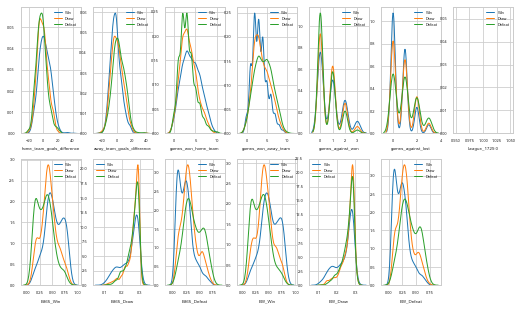

Win       0.455589
Defeat    0.285714
Draw      0.258696
Name: label, dtype: float64


In [71]:
#Exploring the data and creating visualizations
labels = inputs.loc[:,'label']
features = inputs.drop('label', axis = 1)
features.head(5)
feature_details = explore_data(features, inputs, path)

### Validation set

* Take last n days from each season as validation set

#### Finding validation indexes

In [326]:
baseline_data= pd.read_csv('baseline_main_data.csv')

In [327]:
season_end = ['2009-05-24 00:00:00', '2010-05-09 00:00:00',
              '2011-05-22 00:00:00', '2012-05-13 00:00:00',
              '2013-05-19 00:00:00', '2014-05-11 00:00:00',
              '2015-05-24 00:00:00']

In [328]:
### Taking last 10 unique dates from each season/ year

unique_dates = pd.DataFrame(pd.DatetimeIndex(data = baseline_data.sort_values(by=['date']).date.unique()))
date_diff = unique_dates.diff(periods=1).fillna(0)
unique_dates2 = pd.concat([date_diff, unique_dates], axis=1)

In [329]:
unique_dates2.columns = ['daydiff', 'date']
unique_dates2['yr'] = unique_dates2.date.dt.year
validation_dates = list(unique_dates2.groupby(by='yr').tail(7)['date'])
validation_dates_str = [str(i) for i in validation_dates]

In [330]:
baseline_validation = baseline_data[baseline_data.date.isin(validation_dates_str)]

In [331]:
baseline_validation.shape

(253, 55)

In [332]:
val_idx = baseline_validation.index

#### Splitting validation and training 

In [346]:
d = pd.DataFrame(pd.DatetimeIndex(baseline_data.date))
d.columns = ['datetime']

baseline_data2 = pd.concat([d, baseline_data], axis=1)
baseline_data2 = pd.DataFrame(baseline_data2)

In [347]:
baseline_data2[:2]

,datetime,home_player_1_overall_rating,home_player_2_overall_rating,home_player_3_overall_rating,home_player_4_overall_rating,home_player_5_overall_rating,home_player_6_overall_rating,home_player_7_overall_rating,home_player_8_overall_rating,home_player_9_overall_rating,...,matching_home_away_lose_ratio,matching_home_away_draw_ratio,matching_home_all_win_ratio,matching_home_all_lose_ratio,matching_home_all_draw_ratio,AWAY_WIN,HOME_WIN,DRAW,TOTAL_GOALS,date
0,2008-08-17,85.0,79.0,88.0,85.0,78.0,74.0,83.0,85.0,86.0,...,0.500000,0.000000,0.6,0.2,0.2,0,0,1,2,2008-08-17 00:00:00
1,2008-08-16,75.0,76.0,85.0,74.0,77.0,72.0,79.0,75.0,85.0,...,0.333333,0.666667,0.2,0.4,0.4,0,1,0,1,2008-08-16 00:00:00


In [348]:
# some datetime features

baseline_data2['yr'] = baseline_data2.datetime.dt.year
baseline_data2['month'] = baseline_data2.datetime.dt.month
baseline_data2['dow'] = baseline_data2.datetime.dt.dayofweek
baseline_data2.drop(['date'], axis=1, inplace=True)

In [353]:
baseline_data2[:3]

,datetime,home_player_1_overall_rating,home_player_2_overall_rating,home_player_3_overall_rating,home_player_4_overall_rating,home_player_5_overall_rating,home_player_6_overall_rating,home_player_7_overall_rating,home_player_8_overall_rating,home_player_9_overall_rating,...,matching_home_all_win_ratio,matching_home_all_lose_ratio,matching_home_all_draw_ratio,AWAY_WIN,HOME_WIN,DRAW,TOTAL_GOALS,yr,month,dow
0,2008-08-17,85.0,79.0,88.0,85.0,78.0,74.0,83.0,85.0,86.0,...,0.6,0.2,0.2,0,0,1,2,2008,8,6
1,2008-08-16,75.0,76.0,85.0,74.0,77.0,72.0,79.0,75.0,85.0,...,0.2,0.4,0.4,0,1,0,1,2008,8,5
2,2008-08-16,78.0,80.0,71.0,61.0,66.0,79.0,78.0,75.0,74.0,...,0.6,0.4,0.0,1,0,0,1,2008,8,5


In [354]:
label_cols = ['AWAY_WIN', 'HOME_WIN', 'DRAW']

In [355]:
data_val = baseline_data2.iloc[val_idx,:]
data_train = baseline_data2.drop(val_idx, axis=0)

In [356]:
data_train.shape, data_val.shape

((2709, 58), (253, 58))

In [357]:
y_val = np.array(data_val.loc[:,['AWAY_WIN', 'HOME_WIN', 'DRAW']])
y_trn = np.array(data_train.loc[:,['AWAY_WIN', 'HOME_WIN', 'DRAW']])

In [360]:
x_val = data_val.drop(label_cols+['datetime'], axis=1)
x_trn = data_train.drop(label_cols+['datetime'], axis=1)

In [361]:
x_trn.shape, x_val.shape

((2709, 54), (253, 54))

### Fitting Model

#### RF Multiclass

In [375]:
# filling NA
x_trn = x_trn.apply(lambda x: x.fillna(x.mean()))

for c in x_val.columns:
    if x_val[c].isna().sum() > 0:
        x_val[c] = x_val[c].fillna(x_trn[c].mean())

In [370]:
rf = RandomForestClassifier(n_estimators=50, oob_score=True)
rf.fit(x_trn, y_trn)
rf.oob_score_

0.7370493417005045

In [376]:
val_preds = rf.predict(x_val)
sum(val_preds == y_val) / len(y_val)

array([0.6916996 , 0.6798419 , 0.81027668])